# Basic usage

Let's try to see whether we can get fbu to work on Oslo-type data. This is basically a copy of the fbu tutorial where I tried to copy in some oslo things. Parameters are not chosen smart, they are only chosen such to show that it works.

Create an instance of PyFBU

In [1]:
import fbu
import numpy as np
import matplotlib.pyplot as plt
import ompy as om
myfbu = fbu.PyFBU()

Supply the input distribution to be unfolded as a 1-dimensional list for N bins, with each entry corresponding to the bin content.

In [2]:
np.random.seed(16541320)
N = 30
# myfbu.data = np.random.uniform(low=200, high=800, size=N)
# myfbu.data[:2] = 0

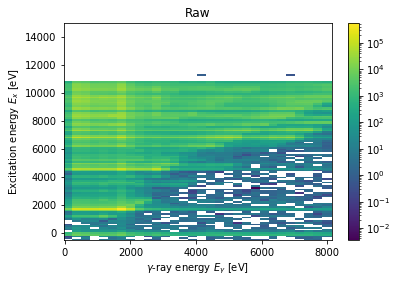

In [3]:
raw = om.example_raw('Si28')
Eg = np.linspace(100,8000, num = N)

raw.rebin("Eg", edges=Eg)
raw.remove_negative()

raw.plot()
raw_py, E = raw.projection(axis="Eg",Emin=6000, Emax=6200)
id_cut = raw.index_Eg(6600)

Supply the response matrix where each row corresponds to a truth level bin.
The normalization of each row must be the acceptance efficiency of the corresponding bin (e.g. the normalization is 1 for resolution only unfolding).
N.B. For now, only squared response matrices are allowed.

In [4]:
folderpath = "~/Desktop/Masterthesis/misc/ompy/oscar_response/oscar2017_scale1.15/"

# Energy calibration of resulting response matrix:
Eg = E

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 30 # (30/1330 = 2.25% )

# Magne recommends 1/10 of the actual resolution for unfolding purposes
response = om.Response(folderpath)
R_ompy_view, R_tab = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)

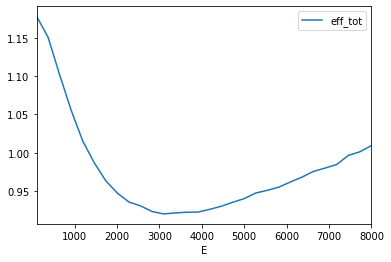

In [5]:
R_tab.plot(x="E", y="eff_tot")
R_ompy_view.values *= R_tab["eff_tot"][:,np.newaxis]

In [6]:
# R_tab.plot(x="E", y="pFE")
# R_tab["pFE"]

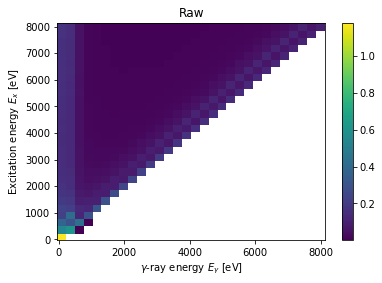

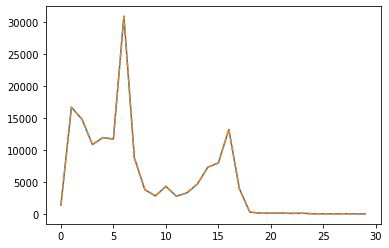

In [7]:
R_ompy_view.plot()

# myfbu.data = raw_py@R_ompy_view.values
myfbu.data = raw_py
fig, ax = plt.subplots()
ax.plot(raw_py, "-")
ax.plot(myfbu.data, "--")
plt.show()

In [8]:
# response = np.zeros((N,N))

# for i in range(N):
# #     if i < 5:
# #         j = 4
# #     else:
# #         j=0
# #     response[i, j:j+2] = 0.5
#     response[i, i] = 0.5
#     if i>3:
#         response[i, i-3] = 0.3
#     response[i, 2]a= 0.3

In [9]:
R_ompy_view.values.shape, myfbu.data.shape

((30, 30), (30,))

In [10]:
# myfbu.response = [[0.08,0.02], #first truth bin
#                   [0.02,0.08]] #second truth bin
# myfbu.response = response
myfbu.response = R_ompy_view.values 

Define the boundaries of the hyperbox to be sampled for each bin.

In [36]:
# myfbu.lower = np.zeros(N)
# # myfbu.upper = np.full_like(myfbu.data, raw_py.max()*1.5)
# myfbu.upper = 2*raw_py
# myfbu.upper[id_cut:] = 5

# The Uniform options help to be able to use NUTS instead of Metropolis
# One should think more about the prior though!!
myfbu.prior = "Uniform"
myfbu.lower = np.zeros(N)
# myfbu.upper = np.full_like(myfbu.data, raw_py.max()*1.5)
myfbu.upper = 4*raw_py
myfbu.upper[id_cut:] = 5

# I first thought that this was smart, but it basically means that we expect the data to closely resemble the
# inital spectrum, doesn't it?
# counts_cut = 30
# myfbu.prior = "ZeroInflatedPoisson"
# myfbu.lower = np.where(myfbu.data>30, 0.001 , 0.5) # fake psi
# myfbu.upper = np.where(myfbu.data>30, myfbu.data/R_tab["pFE"] , 5) # fake theta = observed of counts
# myfbu.upper *= myfbu.data.sum()/myfbu.upper.sum()

In [37]:
print(myfbu.lower), print(myfbu.upper)
print(raw_py.sum(), myfbu.upper.sum(), myfbu.data.sum())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[5.50146983e+03 6.68369526e+04 5.93843165e+04 4.35025554e+04
 4.78032297e+04 4.69138990e+04 1.23853206e+05 3.50826250e+04
 1.51758534e+04 1.12988356e+04 1.72715240e+04 1.11565868e+04
 1.31874323e+04 1.87084230e+04 2.93131798e+04 3.19227599e+04
 5.29848344e+04 1.58822925e+04 1.18159606e+03 4.82260468e+02
 4.71275246e+02 5.09130542e+02 3.63776478e+02 4.49104064e+02
 5.00000000e+00 5.00000000e+00 5.00000000e+00 5.00000000e+00
 5.00000000e+00 5.00000000e+00]
162443.00600369458 649267.1188423645 162443.00600369458


Run the MCMC sampling (this step might take up to several minutes for a large number of bins).

In [38]:
%matplotlib inline
myfbu.nCores = 2
myfbu.nMCMC = 5000
myfbu.monitoring = True
myfbu.run()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [truth29, truth28, truth27, truth26, truth25, truth24, truth23, truth22, truth21, truth20, truth19, truth18, truth17, truth16, truth15, truth14, truth13, truth12, truth11, truth10, truth9, truth8, truth7, truth6, truth5, truth4, truth3, truth2, truth1, truth0]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:43<00:00, 274.43draws/s]


Elapsed 0:00:57 (207.09 samples/second)


Retrieve the N-dimensional posterior distribution in the form of a list of N arrays.

Note: If we get the (exact(!)) same value for different samples in each row, then we proably specified a illdefined prior 

In [ ]:
trace = myfbu.trace
print(trace)

Each array corresponds to the projection of the posterior distribution for a given bin.

In [40]:
# %matplotlib inline
# from matplotlib import pyplot as plt
# plt.hist(trace[10],
#          bins=20,alpha=0.85,
#          normed=raw_py)
# plt.ylabel('probability')

This shows that we have a problem with the current response function/interpolation/binning: There shouldn't be so many counts at the lowest energies.

<IPython.core.display.Javascript object>


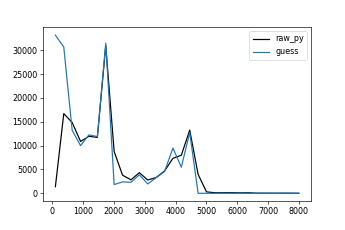

In [45]:
guess = np.zeros_like(raw_py)
guess[6] = 1.1e5
guess[10] = 1.1e4
guess[16] = 8e4
guess = guess@R_ompy_view.values

fig, ax = plt.subplots()
ax.plot(E, raw_py, "k-", label="raw_py")
ax.plot(E, guess, label="guess")
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


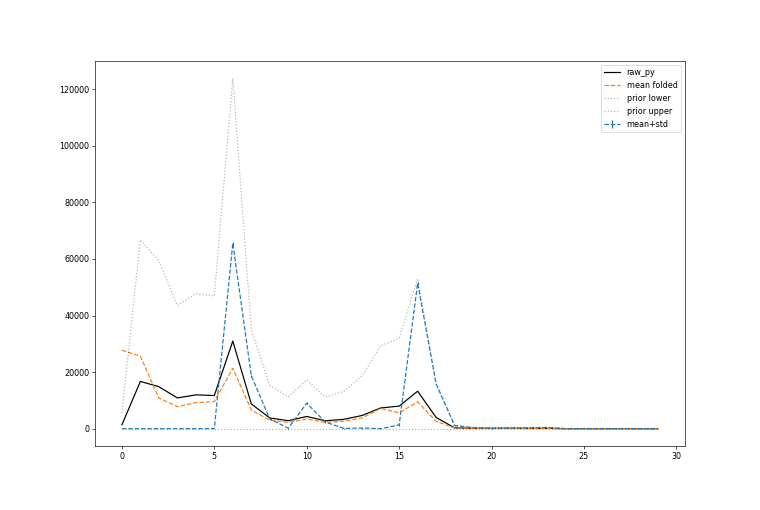

In [43]:
%matplotlib notebook
%matplotlib notebook
mean = np.mean(trace, axis=1)
std = np.std(trace, axis=1)
fig, ax = plt.subplots()
ax.plot(raw_py, "k-", label="raw_py")
ax.errorbar(range(N), mean, yerr=std, fmt="--", label="mean+std")
ax.plot(range(N), mean@R_ompy_view.values, "--", label="mean folded")
ax.plot(range(N), myfbu.lower, "k:", alpha=0.3, label="prior lower")
ax.plot(range(N), myfbu.upper, "k:", alpha=0.3, label="prior upper")
ax.legend()
plt.show()

The output below was from running a discrete uniform prior and therefore a Metropolis sampler. This gane much higher variations -> Uncertainties. It will not look the same when rerunning, as I changed the input above.

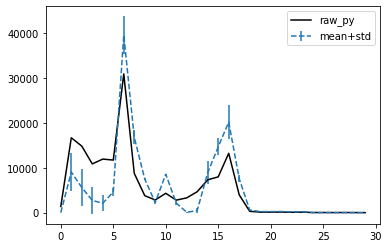

In [18]:
mean = np.mean(trace, axis=1)
std = np.std(trace, axis=1)
fig, ax = plt.subplots()
ax.plot(raw_py, "k-", label="raw_py")
ax.errorbar(range(N), mean, yerr=std, fmt="--", label="mean+std")
ax.legend()
plt.show()

In [19]:
# guttormsen unfolding
# We need to remove negative counts (unphysical) in the raw matrix before unfolding:
R_ompy_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10)
raw_dummy = np.array([myfbu.data, myfbu.data])
# print(raw_dummy.shape)
raw_dummy = om.Matrix(raw_dummy, Eg=Eg, Ex=np.array([20, 40]))
raw_dummy.verify_integrity()
raw_dummy.remove_negative()
# print(myfbu.data.shape, Eg.shape, raw_dummy.Ex.shape)
# raw_dummy.plot()

# With compton subtraction and all tweaks
unfolder= om.Unfolder(response=R_ompy_unf)
unfolder.use_compton_subtraction = False # default
# unfolder.response_tab = R_tab_unf
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
# unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
#                                      "de": 1.3, "511": 0.9}
unfolded = unfolder(raw_dummy)
unfolded = unfolded[0,:]
# unfolded.plot();

In [20]:
trace = np.array(trace)

In [21]:
%matplotlib notebook
%matplotlib notebook
mean = np.mean(trace, axis=1)
std = np.std(trace, axis=1)

fbu_folded = mean@R_ompy_view.values
mama_folded = unfolded@R_ompy_view.values

<IPython.core.display.Javascript object>


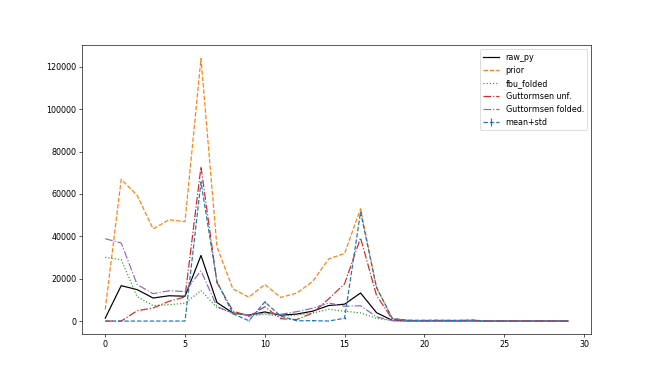

In [46]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.plot(raw_py, "k-", label="raw_py")
ax.errorbar(range(N), mean, yerr=std, fmt="--", label="mean+std")
ax.plot(range(N), myfbu.upper, "--", label="prior")
ax.plot(range(N), fbu_folded, ":", label="fbu_folded")
ax.plot(range(N), unfolded, "-.", label="Guttormsen unf.")
ax.plot(range(N), mama_folded, "-.", label="Guttormsen folded.")
ax.legend()
plt.show()